In [1]:
import argparse
import configparser
import pandas as pd
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from scipy import stats as st
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dummy', nargs='?', default='None')
parser.add_argument('--s3-bucket', nargs='?', default='bucket', type=str)
parser.add_argument('--s3-prefix', nargs='?', default='prefix/', type=str)
parser.add_argument('--last-n-days', nargs='?', default='30', type=int)
parser.add_argument('--use-cols', nargs='*', default='30', type=int)

parser.add_argument('--num-samples', nargs='*', default=1000, type=int)
parser.add_argument('--num-burnin', nargs='*', default=5000, type=int)

parser.add_argument("-c", "--config", dest='config_file', default='config.ini', type=str);

args = parser.parse_args(args=['--dummy'])
#config = configparser.ConfigParser()
#config.read(args.config_file)
#use_cols = config.get('main', 'use_cols').split(',')

In [3]:
class Data():
    
    def __init__(self, bucket, prefix, last_n_days=30):
        self.last_n_days = last_n_days
        self.bucket = bucket
        self.prefix = prefix
        self.unique_attrs = ['linename', 'subtrackname', 'Aligned Chainage', 'vehicle']
        self.useful_cols = ['linename', 'subtrackname', 'km', 'vehicle', 'datetime',
                            'acc', 'lat_jerk', 'lon_jerk', 'gauge', 'bolaccy', 'Aligned Chainage']
        self.df_raw = None
        self.df_processed = None
        self.df_result = None
        self.dates = []
        self.files = []
        self._get_path_list()
        
    def _get_path_list(self):
        s3 = boto3.resource('s3', region_name='ap-east-1')
        objs = list(s3.Bucket(self.bucket).objects.filter(Prefix=self.prefix))
        for i in range(1, len(objs)):
            self.files.append(objs[i].key)
            self.dates.append(objs[i].key.rsplit('/',4)[3].rsplit('.',2)[0])
        
    def _get_raw_generator(self):
        for date in self.dates[-self.last_n_days:]:
            df = pd.read_parquet(f's3://{self.bucket}/{self.prefix}{date}.parquet', columns=self.useful_cols)
            yield df
            
    def _get_max_sub_df(self, df, attr):
        attr_max = df[attr].value_counts().index[0]
        mask = df[attr] == attr_max
        return df[mask]
    
    @classmethod
    def get_one_sample(cls, bucket, prefix):       
        data = cls(bucket, prefix, 1)
        df = pd.read_parquet(f's3://{data.bucket}/{data.prefix}{data.dates[-1]}.parquet')
        return df

    @staticmethod
    def check_na(df, threshold=0.3):       
        df_na = df.isna().sum()/df.shape[0]
        return df_na[df_na>=threshold]
            
    def get_raw_generator(self):
        self.df_raw = pd.concat(list(self._get_raw_generator()))
        self.df_processed = self.df_raw
    
    def get_example(self):
        for attr in self.unique_attrs:
            self.df_processed = self._get_max_sub_df(self.df_processed, attr)
        
    def preprocessing(self):
        self.df_processed = self.df_processed.drop_duplicates('datetime').sort_values(by='datetime')
        #self.df_processed['gauge'] = self.df_processed['gauge'].interpolate(limit=2)
        
    def scatter_plot_chainage_hue(self, chainage=2.1, direction='Down'):            
        mask1 = self.df_processed['Aligned Chainage'] == chainage
        mask2 = self.df_processed['subtrackname'].str.contains(direction)
        df = self.df_processed[mask1&mask2]
        fig, axes = plt.subplots(2,3, figsize=(16, 8))
        fig.suptitle(f'chainage={chainage}, direction={direction}')
        sns.scatterplot(data=df, hue='km', x='datetime', y='acc', ax=axes[0, 0])#.set_title('acc')
        sns.scatterplot(data=df, hue='km', x='datetime', y='bolaccy', ax=axes[0, 1])#.set_title('bolaccy')
        sns.scatterplot(data=df, hue='km', x='datetime', y='gauge', ax=axes[0, 2])#.set_title('gauge')
        sns.scatterplot(data=df, hue='vehicle', x='datetime', y='acc', ax=axes[1, 0])#.set_title('acc')
        sns.scatterplot(data=df, hue='vehicle', x='datetime', y='bolaccy', ax=axes[1, 1])#.set_title('bolaccy')
        sns.scatterplot(data=df, hue='vehicle', x='datetime', y='gauge', ax=axes[1, 2])#.set_title('gauge')
        fig.autofmt_xdate()
        plt.show()
            
    def sub_df(self, chainage=2.1, direction='Down', target='gauge'):
        mask1 = self.df_processed['Aligned Chainage'] == chainage
        mask2 = self.df_processed['subtrackname'].str.contains(direction)
        df = self.df_processed[mask1&mask2]
        df = df[['datetime', target]]
        df = df.set_index('datetime')
        return df
    

In [ ]:
# check if any schema change
df_sample = Data.get_one_sample(args.s3_bucket, args.s3_prefix)
df_sample.columns

In [ ]:
# check na%
Data.check_na(df_sample, 0.3)

In [6]:
data = Data(args.s3_bucket, args.s3_prefix, args.last_n_days)
data.get_raw_generator()
data.preprocessing()

In [ ]:
data.df_processed

In [65]:
import abc

class BayesModel(metaclass=abc.ABCMeta):
    
    def __init__(self, y, t, dt, num_samples=1000, num_burnin=2000, threshold_t=24):
        self.model = pm.Model()
        self.y = y
        self.t = t
        self.dt = dt
        self.N = y.shape[0]
        self.threshold_t = threshold_t
        self.num_samples = num_samples
        self.num_burnin = num_burnin
        self.trace = []
   
    @staticmethod
    def dt2t(dt):
        return ((dt - dt[0]).total_seconds().astype(int)//3600).values
        
    @classmethod
    def from_df(cls, df, num_samples=1000, num_burnin=2000, threshold_t=24):
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        # check difference
        sns.scatterplot(data=df, x=df.index, y=df.columns[0], ax=axes[0])
        axes[0].set_title('pre-preprocessing')
        
        # preprocessing
        #self.df = self.df.assign(week=self.df.index.isocalendar().week)
        #self.df[target] = self.df.groupby(['week'])[target].transform(lambda x: x.clip(x.quantile(0.05), x.quantile(0.95)))
        #self.df = self.df.drop(['week'], axis=1)
        df = df.resample('h').mean().dropna()
        
        # check difference
        sns.scatterplot(data=df, x=df.index, y=df.columns[0], ax=axes[1])
        axes[1].set_title('post-preprocessing')
        #fig.autofmt_xdate(rotation=90)
        #axes[0].set_xticks(axes[0].get_xticks()[::2])
        #axes[1].set_xticks(axes[1].get_xticks()[::2])
        fig.tight_layout()    
        
        y = df.values.flatten()
        dt = df.index
        t = cls.dt2t(dt)
        return cls(y, t, dt, num_samples=num_samples, num_burnin=num_burnin, threshold_t=threshold_t)
    
    @staticmethod
    def sample_data(N=100, sp_loc=0.7, mu_1=1440, mu_2=1445, beta_1=0.03, beta_2=0.1, sigma_1=0.3, sigma_2=0.6):
        N = N
        sp = int(N*sp_loc)
        t = np.arange(0, N)
        eps_1 = np.random.normal(0, sigma_1, sp)
        eps_2 = np.random.normal(0, sigma_2, N-sp)
        y_1 = mu_1+beta_1*t[:sp] + eps_1
        y_2 = mu_2+beta_2*(t[sp:]-sp) + eps_2
        y = np.concatenate((y_1, y_2))

        start = pd.to_datetime('2021-06-01')
        dt = start + pd.TimedeltaIndex(t, unit='hour') 
        _, ax = plt.subplots(figsize=(12, 6))
        sns.scatterplot(y=y, x=dt, ax=ax)
        plt.show()
        return y, t, dt 
        
    def get_t(self):
        return ((self.dt - self.dt[0]).total_seconds().astype(int)//3600).values
            
    def t2dt(self, t):
        # t to datetime
        return self.dt[0] + pd.Timedelta(hours=t)

    @abc.abstractmethod
    def define_model(self):
        return NotImplemented
        
    def fit(self):
        with self.model:
            self.trace = pm.sample(self.num_samples, tune=self.num_burnin, return_inferencedata=True)

    def _get_posterior_parm(self, arr, parm, val_type='float', stats='median'):
        N = len(arr)
        if stats == 'median':
            #arr = np.round(trace['switch'][samples//2:]).astype(int)
            #counts = np.bincount(arr)
            #switchpoint_post = np.argmax(counts)
            parm_p = np.median(arr[parm][N//2:])
        elif stats == 'mean':
            parm_p = np.mean(arr[parm][N//2:])

        if val_type == 'int':
            parm_p = np.round(parm_p).astype(int)
        return parm_p
    
    def plot_trace(self):
        with self.model:
            pm.plot_trace(self.trace)
            plt.show()

    @abc.abstractmethod
    def plot_posterior_predictive(self):   
        return NotImplemented
            
    #def plot_linear_model(self):
    #    with self.model:
    #        switchpoint_post = self._get_posterior_parm(self.trace, 'switch', val_type='int')
    #        mu_1_post = self._get_posterior_parm(self.trace, 'mu_1')
    #        mu_2_post = self._get_posterior_parm(self.trace, 'mu_2')
    #        beta_1_post = self._get_posterior_parm(self.trace, 'beta_1')
    #        beta_2_post = self._get_posterior_parm(self.trace, 'beta_2')
    #        sigma_1_post = self._get_posterior_parm(self.trace, 'sigma_1')
    #        sigma_2_post = self._get_posterior_parm(self.trace, 'sigma_2')
    #        sigma_sensor_post = self._get_posterior_parm(self.trace, 'sigma_sensor')
    #        y1_post = mu_1_post+beta_1_post*self.t[:switchpoint_post]
    #        y2_post = mu_2_post+beta_2_post*(self.t[switchpoint_post:]-switchpoint_post)
    #        y_post = np.concatenate((y1_post, y2_post))
    
    #        sns.scatterplot(data=self.y)
    #        plt.plot(range(switchpoint_post), y1_post, color='red')
    #        plt.plot(range(switchpoint_post, self.t), y2_post, color='red')
    #        plt.fill_between(range(switchpoint_post), y1_post-2*(sigma_1_post+sigma_sensor_post), y1_post+2*(sigma_1_post+sigma_sensor_post), alpha=.3)
    #        plt.fill_between(range(switchpoint_post, self.N), y2_post-2*(sigma_2_post+sigma_sensor_post), y2_post+2*(sigma_2_post+sigma_sensor_post), alpha=.3)
    #        plt.axvline(x=switchpoint_post, ls='--', c='blue')
    #        plt.title(f'RMSE: {rmse:.2f}')
    #        plt.show()

    
class SwitchPointBasicModel(BayesModel):
        
    def define_model(self):
        clipped_y = np.clip(self.y, *np.nanquantile(self.y, (0.1, 0.9)))
        early_coeff_std = np.nanstd(np.diff(clipped_y[:self.N//2], n=1, axis=0))
        late_coeff_std = np.nanstd(np.diff(clipped_y[self.N//2:], n=1, axis=0))
        early_p50 = np.nanquantile(self.y[:self.N//2], 0.5)
        late_p50 = np.nanquantile(self.y[self.N//2:], 0.5)
        early_std = np.nanstd(self.y[:self.N//2])
        late_std = np.nanstd(self.y[self.N//2:])
        sensor_mu = np.nanstd(np.clip(self.y, *np.nanquantile(self.y, (0.25, 0.75))))
        sensor_std = np.nanstd(self.y)
        with self.model:
            # switch, weight, time multiplier with coefficient
            switchpoint = pm.Uniform("switch", lower=self.threshold_t, upper=self.t[-1] - self.threshold_t, testval=self.t[-1]//2)
            w = pm.math.sigmoid(2*(self.t-switchpoint))
            t_ = (1-w)*self.t + w*(self.t-switchpoint)

            # intercept
            mu_1 = pm.Normal("mu_1", mu=early_p50, sigma=early_std)
            mu_2 = pm.Normal("mu_2", mu=late_p50, sigma=late_std)
            mu_ = pm.Deterministic("y_mu", (1-w)*mu_1 + w*mu_2)

            # error term
            #sigma_sensor = pm.HalfNormal("sigma_sensor", sigma=2*sensor_std, testval=sensor_mu)
            #sigma_sensor = sensor_std
            sigma_1 = pm.HalfNormal("sigma_1", sigma=early_std*2, testval=early_std)
            sigma_2 = pm.HalfCauchy("sigma_2", beta=late_std*2, testval=late_std)
            sigma_ = pm.Deterministic("y_sigma", (1-w)*(sigma_1) + w*(sigma_2))

            nu = pm.Gamma('nu', alpha=2, beta=0.1)

            # likelihood  
            y_obs = pm.StudentT("obs", nu=nu, mu=mu_, sigma=sigma_, observed=self.y)
    
    def plot_posterior_predictive(self):
        with self.model:
            ppc = pm.sample_posterior_predictive(self.trace, var_names=["y_mu", "obs", "switch"])
                
            mu_pp = (ppc["y_mu"])
            mu_hpd = az.hdi(mu_pp)
            obs_hpd = az.hdi(ppc['obs'])
            switchpoint_pp = self._get_posterior_parm(ppc, 'switch', val_type='int')
            sp_hpd = az.hdi(ppc['switch'])
            
            _, ax = plt.subplots(figsize=(16, 8))  
            ax.plot(self.dt, self.y, "o", ms=4, alpha=0.4, label="Data")     
            ax.fill_between(self.dt, obs_hpd[:,0], obs_hpd[:,1], color='lightblue', alpha=0.8, label="Obs y 94% HPD")
            
            ax.plot(self.dt, mu_pp.mean(0), color='darkorange', alpha=0.6, label="Mean y")
            ax.fill_between(self.dt, mu_hpd[:,0], mu_hpd[:,1], color='orange', alpha=0.8, label="Mean y 94% HPD")
            
            ax.axvline(x=self.t2dt(switchpoint_pp), ls='--', c='black', label='switchpoint')
            ax.axvline(x=self.t2dt(sp_hpd[0]), ls='--', c='grey', label='switchpoint 94% HPD')
            ax.axvline(x=self.t2dt(sp_hpd[1]), ls='--', c='grey')
            
            ax.set_xlabel("datetime")
            ax.set_ylabel("y")
            ax.set_title("Continous Posterior predictive checks")
            ax.legend(ncol=2, fontsize=10)
            plt.show()           

    
class SwitchPointModel(BayesModel):
        
    def define_model(self):
        clipped_y = np.clip(self.y, *np.nanquantile(self.y, (0.1, 0.9)))
        early_coeff_std = np.nanstd(np.diff(clipped_y[:self.N//2], n=1, axis=0))
        late_coeff_std = np.nanstd(np.diff(clipped_y[self.N//2:], n=1, axis=0))
        early_p10 = np.nanquantile(self.y[:self.N//2], 0.1)
        late_p10 = np.nanquantile(self.y[self.N//2:], 0.1)
        early_std = np.nanstd(self.y[:self.N//2])
        late_std = np.nanstd(self.y[self.N//2:])
        sensor_mu = np.nanstd(np.clip(self.y, *np.nanquantile(self.y, (0.25, 0.75))))
        sensor_std = np.nanstd(self.y)
        with self.model:
            # switch, weight, time multiplier with coefficient
            switchpoint = pm.Uniform("switch", lower=self.threshold_t, upper=self.t[-1] - self.threshold_t, testval=self.t[-1]//2)
            w = pm.math.sigmoid(2*(self.t-switchpoint))
            t_ = (1-w)*self.t + w*(self.t-switchpoint)

            # intercept
            mu_1 = pm.Normal("mu_1", mu=early_p10, sigma=early_std)
            mu_2 = pm.Normal("mu_2", mu=late_p10, sigma=late_std)
            mu_ = pm.Deterministic("y_mu", (1-w)*mu_1 + w*mu_2)

            # coefficient
            beta_1 = pm.HalfNormal('beta_1', sigma=early_coeff_std)
            beta_2 = pm.HalfCauchy('beta_2', beta=late_coeff_std)
            beta_ = pm.Deterministic("y_beta", (1-w)*beta_1 + w*beta_2)

            # error term
            sigma_sensor = pm.HalfNormal("sigma_sensor", sigma=2*sensor_std, testval=sensor_mu)
            #sigma_sensor = sensor_std
            sigma_1 = pm.HalfNormal("sigma_1", sigma=early_std*2, testval=early_std)
            sigma_2 = pm.HalfCauchy("sigma_2", beta=late_std*2, testval=late_std)
            sigma_ = pm.Deterministic("y_sigma", (1-w)*(sigma_1+sigma_sensor) + w*(sigma_2+sigma_sensor))

            nu = pm.Gamma('nu', alpha=2, beta=0.1)

            # likelihood  
            y_obs = pm.StudentT("obs", nu=nu, mu=mu_+beta_*t_, sigma=sigma_, observed=self.y)
    
    def plot_posterior_predictive(self):
        with self.model:
            ppc = pm.sample_posterior_predictive(self.trace, var_names=["y_mu", "y_beta", "obs", "switch"])

            xs = np.tile(self.t, (4000, 1))
            xs_mask = xs - ppc['switch'][:,None] > 0
            for x, mask, switchpoint in zip(xs, xs_mask, ppc['switch']):
                x[mask] = x[mask] - switchpoint
                
            mu_pp = (ppc["y_mu"] + ppc["y_beta"] * xs)
            mu_hpd = az.hdi(mu_pp)
            obs_hpd = az.hdi(ppc['obs'])
            switchpoint_pp = self._get_posterior_parm(ppc, 'switch', val_type='int')
            sp_hpd = az.hdi(ppc['switch'])
            
            _, ax = plt.subplots(figsize=(16, 8))  
            ax.plot(self.dt, self.y, "o", ms=4, alpha=0.4, label="Data")     
            ax.fill_between(self.dt, obs_hpd[:,0], obs_hpd[:,1], color='lightblue', alpha=0.8, label="Obs y 94% HPD")
            
            ax.plot(self.dt, mu_pp.mean(0), color='darkorange', alpha=0.6, label="Mean y")
            ax.fill_between(self.dt, mu_hpd[:,0], mu_hpd[:,1], color='orange', alpha=0.8, label="Mean y 94% HPD")
            
            ax.axvline(x=self.t2dt(switchpoint_pp), ls='--', c='black', label='switchpoint')
            ax.axvline(x=self.t2dt(sp_hpd[0]), ls='--', c='grey', label='switchpoint 94% HPD')
            ax.axvline(x=self.t2dt(sp_hpd[1]), ls='--', c='grey')
            
            ax.set_xlabel("datetime")
            ax.set_ylabel("y")
            ax.set_title("Continous Posterior predictive checks")
            ax.legend(ncol=2, fontsize=10)
            plt.show()           


class GaussianProcessModel(BayesModel):
        
    def define_model(self):
        clipped_y = np.clip(self.y, *np.nanquantile(self.y, (0.1, 0.9)))
        early_coeff_std = np.nanstd(np.diff(clipped_y[:self.N//2], n=1, axis=0))
        late_coeff_std = np.nanstd(np.diff(clipped_y[self.N//2:], n=1, axis=0))
        early_p10 = np.nanquantile(self.y[:self.N//2], 0.1)
        late_p10 = np.nanquantile(self.y[self.N//2:], 0.1)
        early_std = np.nanstd(self.y[:self.N//2])
        late_std = np.nanstd(self.y[self.N//2:])
        sensor_mu = np.nanstd(np.clip(self.y, *np.nanquantile(self.y, (0.25, 0.75))))
        sensor_std = np.nanstd(self.y)
        with self.model:
            ## intercept
            #sigma_ = pm.HalfNormal("sigma_", sigma=early_std*2, testval=early_std)
            #mu_drift = pm.Normal('mu_drift', mu=early_p10, sigma=early_std)      
            #mu_ = pm.GaussianRandomWalk('mu_', mu=mu_drift, sd=sigma_, shape=self.y.shape[0])
            #
            ## error term
            #
            #
            #nu = pm.Gamma('nu', alpha=2, beta=0.1)

            ## likelihood  
            #y_obs = pm.StudentT("obs", nu=nu, mu=mu_, sigma=sigma_sensor, observed=self.y)
            
            
            sigma_sensor = pm.HalfNormal("sigma_sensor", sigma=2*sensor_std, testval=sensor_mu)
            
            sigma_ = pm.HalfCauchy('sigma_', beta=self.y.std())
            mu_drift = pm.Normal('mu_drift', mu=self.y.mean(), sigma=self.y.std())
            mu_ = pm.GaussianRandomWalk('y_mu', mu=mu_drift, sd=sigma_, shape=self.y.size)
            nu = pm.Gamma('nu', alpha=2, beta=0.1)
            y_obs = pm.StudentT('obs', mu=mu_, sigma=sigma_sensor, nu=nu, observed=self.y)
    
    def plot_posterior_predictive(self):
        with self.model:
            ppc = pm.sample_posterior_predictive(self.trace, var_names=["y_mu", "obs"])
                
            mu_pp = ppc["y_mu"]
            mu_hpd = az.hdi(mu_pp)
            obs_hpd = az.hdi(ppc['obs'])
            
            _, ax = plt.subplots(figsize=(16, 8))  
            ax.plot(self.dt, self.y, "o", ms=4, alpha=0.4, label="Data")     
            ax.fill_between(self.dt, obs_hpd[:,0], obs_hpd[:,1], color='lightblue', alpha=0.8, label="Obs y 94% HPD")
            
            ax.plot(self.dt, mu_pp.mean(0), color='darkorange', alpha=0.6, label="Mean y")
            ax.fill_between(self.dt, mu_hpd[:,0], mu_hpd[:,1], color='orange', alpha=0.8, label="Mean y 94% HPD")
            
            ax.set_xlabel("datetime")
            ax.set_ylabel("y")
            ax.set_title("Continous Posterior predictive checks")
            ax.legend(ncol=2, fontsize=10)
            plt.show()       
            

# Experiment

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_2, sigma_1, mu_2, mu_1, switch]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 10% for some parameters.


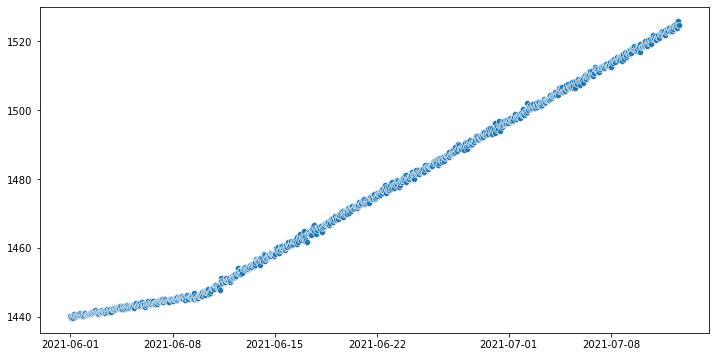

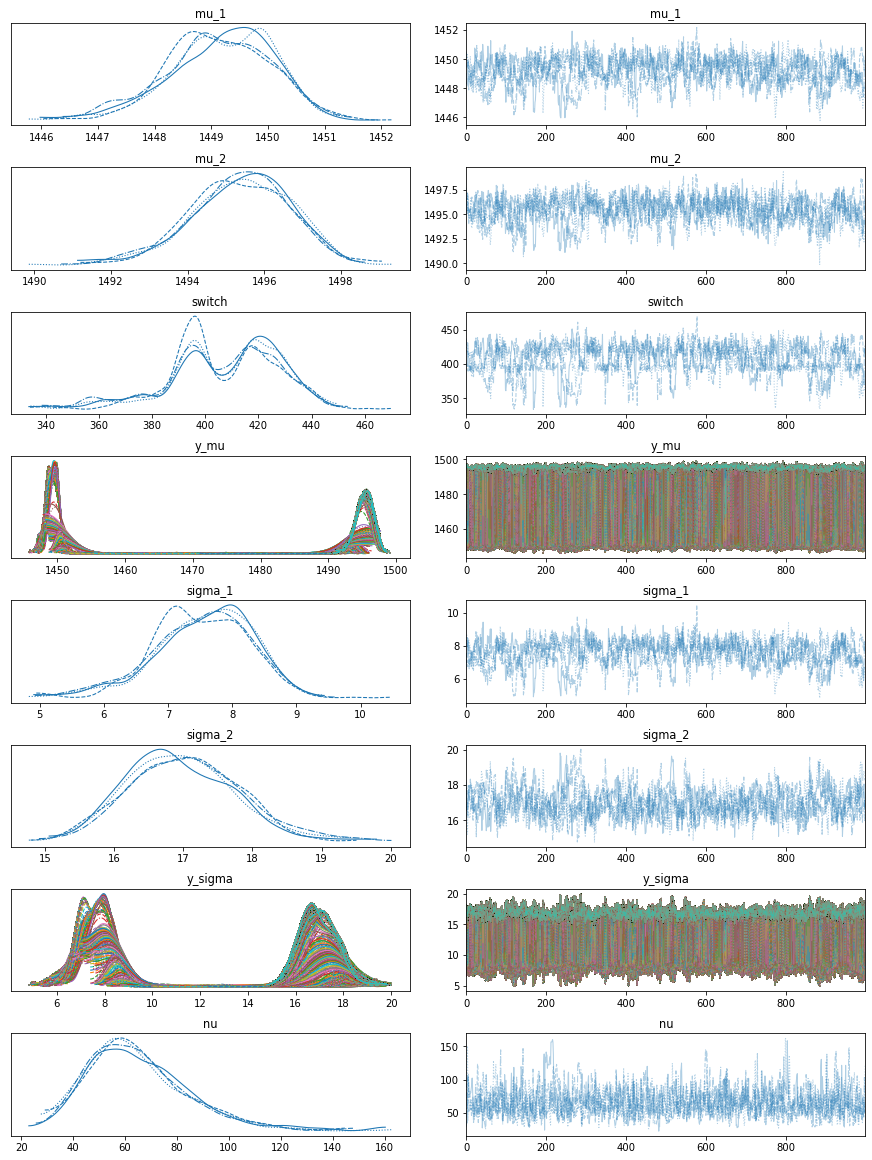

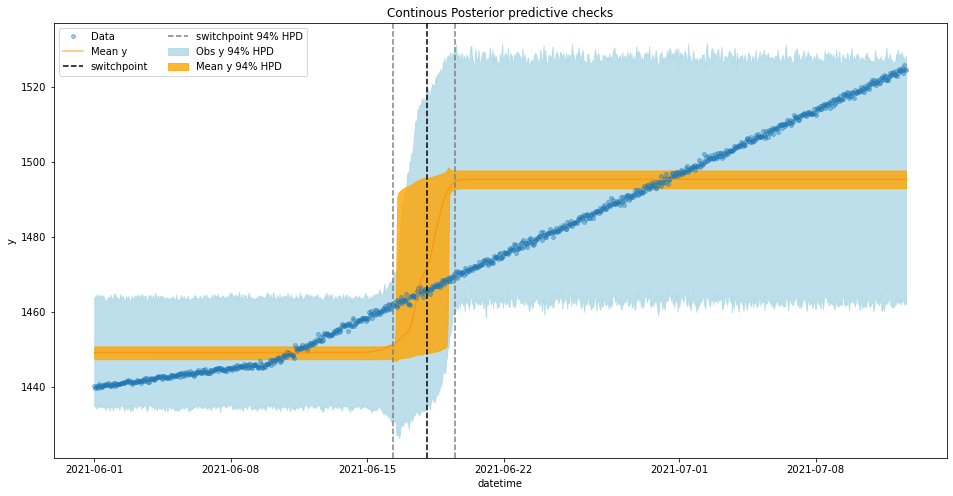

In [64]:
sample_data = SwitchPointBasicModel.sample_data(N=1000, sp_loc=0.2, mu_1=1440, mu_2=1445, beta_1=0.03, beta_2=0.1, sigma_1=0.3, sigma_2=0.6)
model = SwitchPointBasicModel(*sample_data)
model.define_model() 
model.fit()
model.plot_trace()
model.plot_posterior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_2, sigma_1, sigma_sensor, beta_2, beta_1, mu_2, mu_1, switch]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 68 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7074519569670062, but should be close to 0.8. Try to increase the number of tuning steps.
There were 368 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33971720183210197, but should be close to 0.8. Try to increase the number of tuning steps.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5511235002637651, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimate

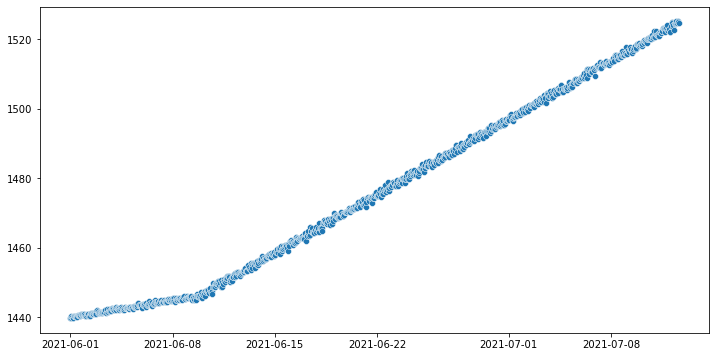

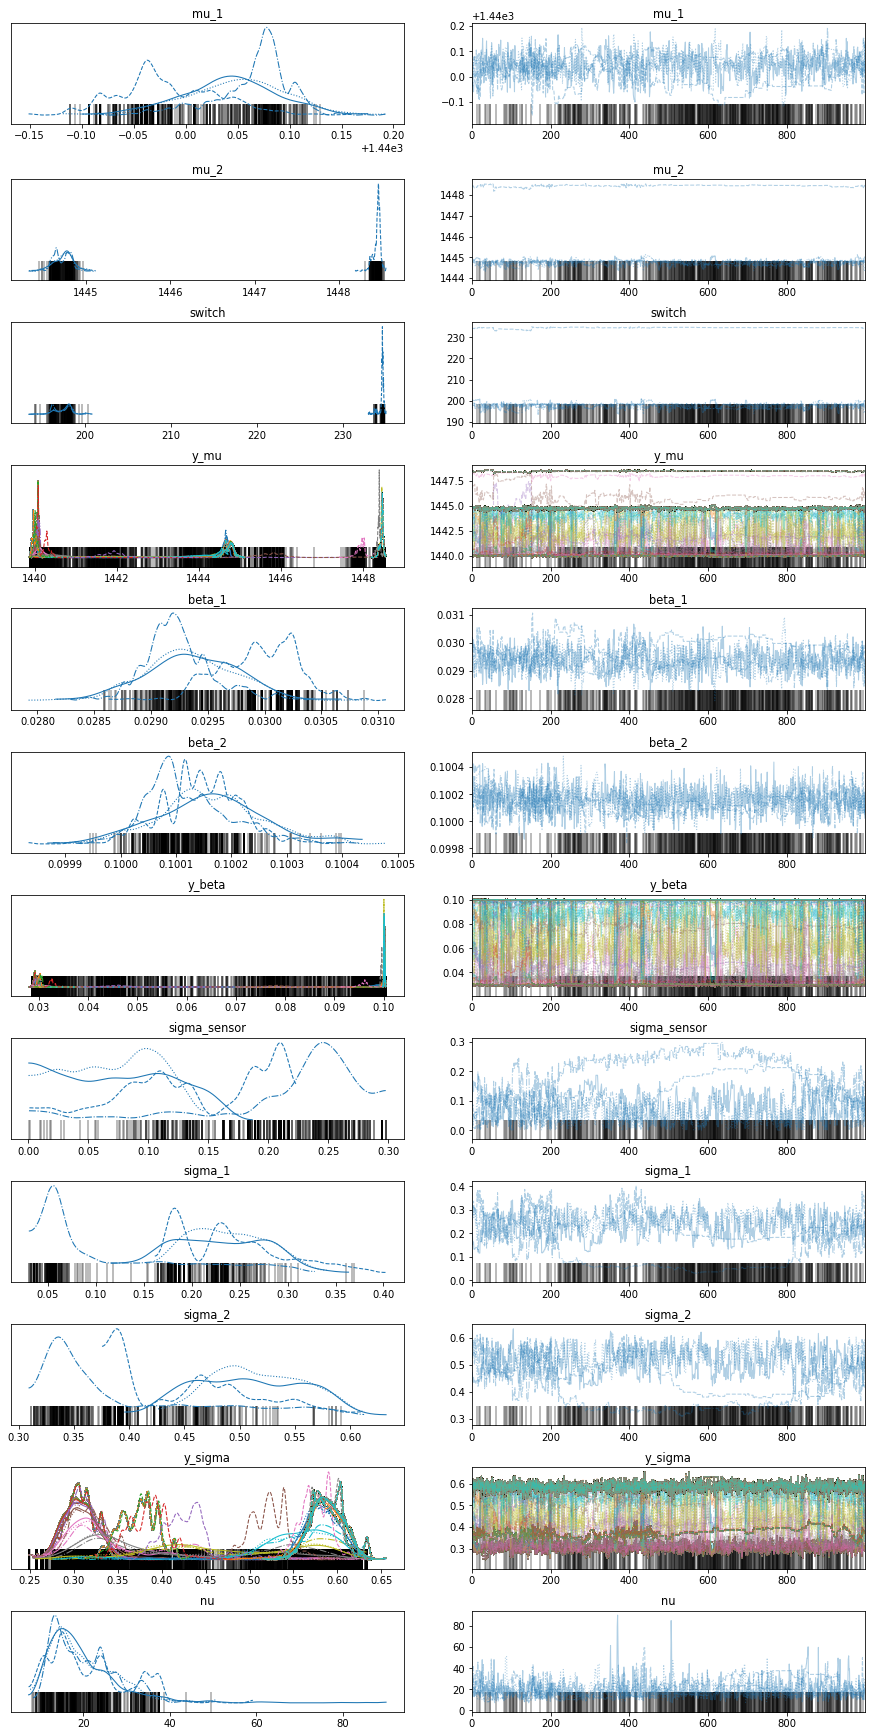

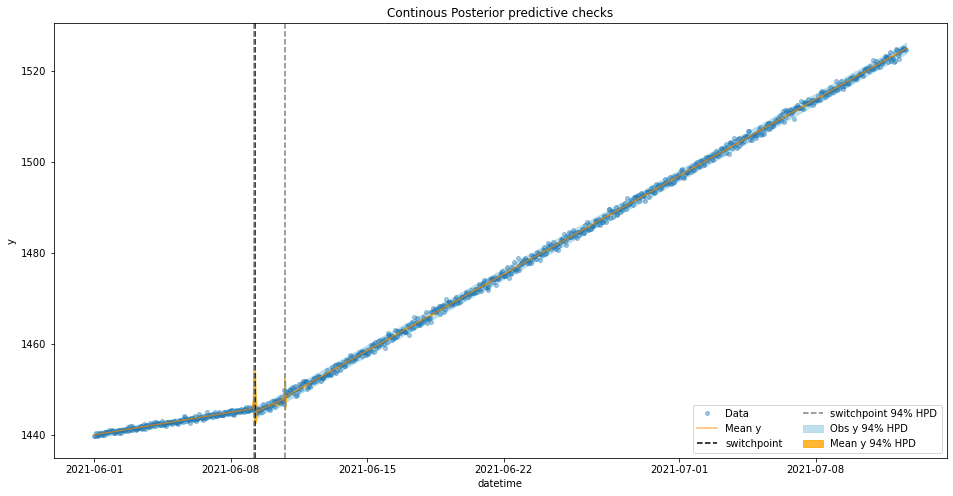

In [67]:
sample_data = SwitchPointModel.sample_data(N=1000, sp_loc=0.2, mu_1=1440, mu_2=1445, beta_1=0.03, beta_2=0.1, sigma_1=0.3, sigma_2=0.6)
model = SwitchPointModel(*sample_data)
model.define_model() 
model.fit()
model.plot_trace()
model.plot_posterior_predictive()